In [10]:
import numpy as np
import pandas as pd
from cryptocmd import CmcScraper
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


from keras.optimizers import Adam

In [11]:
coins = ['btc', 'eth', 'aave', 'doge', 'xrp']
coin_names = ['Bitcoin', 'Ethereum', 'Aave', 'Dogecoin', 'XRP']
df_dict = {}
scaled_coins = {}

for coin, name in zip(coins, coin_names):
    scraper = CmcScraper(coin_code=coin, coin_name=name)
    df = scraper.get_dataframe()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns_to_scale = ['Open', 'Low', 'Close', 'Volume', 'Market Cap', 'High']
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale, index=df.index)
    scaled_coins[name] = df_scaled

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
def perform_k_fold_cv_without(dataframe, n_splits=5, random_state=42, n_lags=1):
    data = series_to_supervised(dataframe, n_lags, 1)
    X, y = data.values[:, :-1], data.values[:, -1]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=0, shuffle=False)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        rmse_scores_train.append(rmse_train)
        rmse_scores_test.append(rmse_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

    avg_rmse_train = np.mean(rmse_scores_train)
    avg_rmse_test = np.mean(rmse_scores_test)
    avg_r2_train = np.mean(r2_scores_train)
    avg_r2_test = np.mean(r2_scores_test)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test

In [14]:
results = {}
for crypto, dataset in scaled_coins.items():
    results[crypto] = perform_k_fold_cv_without(dataset)

df_results = pd.DataFrame(results, index=['avg_rmse_train', 'avg_rmse_test', 'avg_r2_train', 'avg_r2_test']).T
print(df_results)

/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
          avg_rmse_train  avg_rmse_test  avg_r2_train  avg_r2_test
Bitcoin         0.023699       0.023782      0.990357     0.990248
Ethereum        0.022719       0.022725      0.990574     0.990628
Aave            0.013000       0.013034      0.995391     0.995042
Dogecoin        0.007260       0.006483      0.995769     0.995630
XRP             0.018922       0.019055      0.962159     0.961095


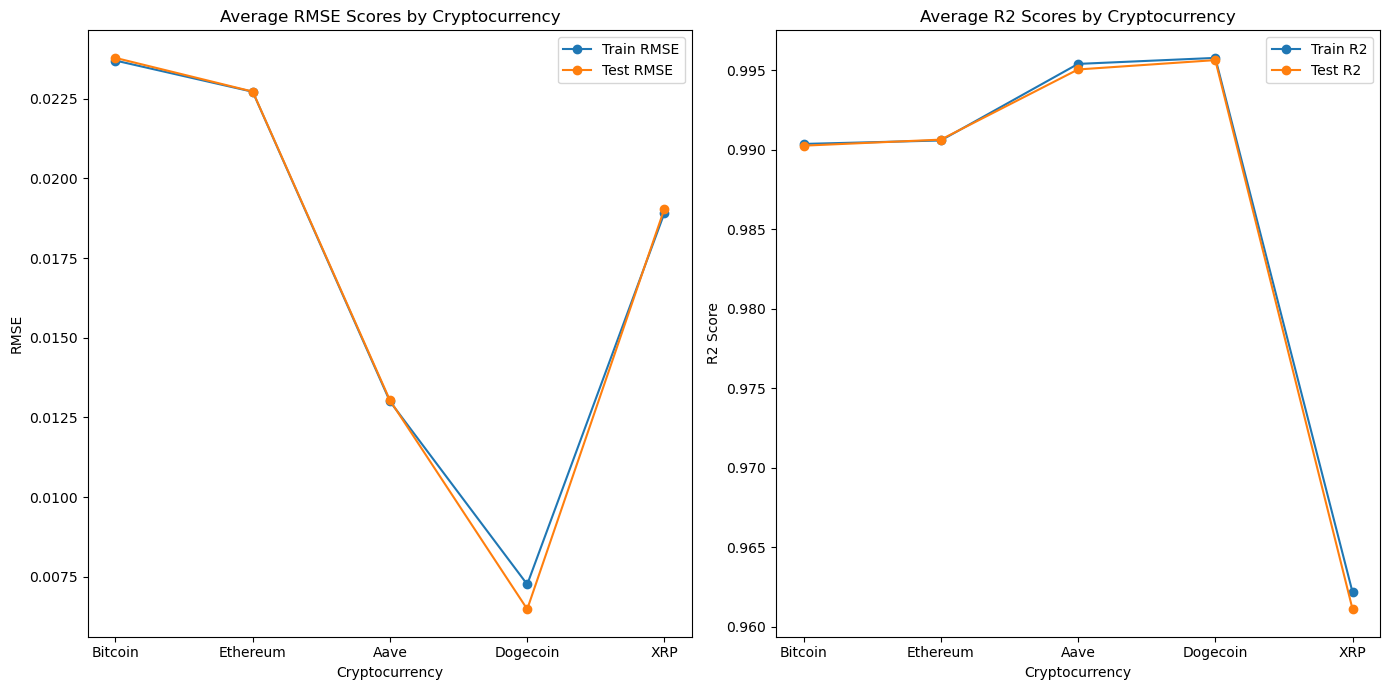

In [15]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def perform_k_fold_cv(dataframe, n_splits=5, random_state=42, n_lags=1, learning_rate=0.01, dropout_rate=0.2):
    data = series_to_supervised(dataframe, n_lags, 1)
    X, y = data.values[:, :-1], data.values[:, -1]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape input to be 3D [samples, timesteps, features] for LSTM
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Define the LSTM model
        model = Sequential([
            LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(dropout_rate),  # Adding dropout
            Dense(1)
        ])

        # Compile the model with the Adam optimizer and a custom learning rate
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        # Fit network
        model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=0, shuffle=False)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute RMSE for the training and test sets
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        rmse_scores_train.append(rmse_train)
        rmse_scores_test.append(rmse_test)

        # Compute R2 score for training and test sets
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

    # Calculate average scores
    avg_rmse_train = np.mean(rmse_scores_train)
    avg_rmse_test = np.mean(rmse_scores_test)
    avg_r2_train = np.mean(r2_scores_train)
    avg_r2_test = np.mean(r2_scores_test)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test

In [17]:
results = {}
for crypto, dataset in scaled_coins.items():
    results[crypto] = perform_k_fold_cv(dataset)

df_results = pd.DataFrame(results, index=['avg_rmse_train', 'avg_rmse_test', 'avg_r2_train', 'avg_r2_test']).T
print(df_results)

/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


/Users/shreyac/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
          avg_rmse_train  avg_rmse_test  avg_r2_train  avg_r2_test
Bitcoin         0.062538       0.063172      0.923822     0.922646
Ethereum        0.049789       0.049821      0.896792     0.901158
Aave            0.028665       0.029287      0.976746     0.976228
Dogecoin        0.042589       0.041881      0.848827     0.850854
XRP             0.025738       0.025431      0.901590     0.904430


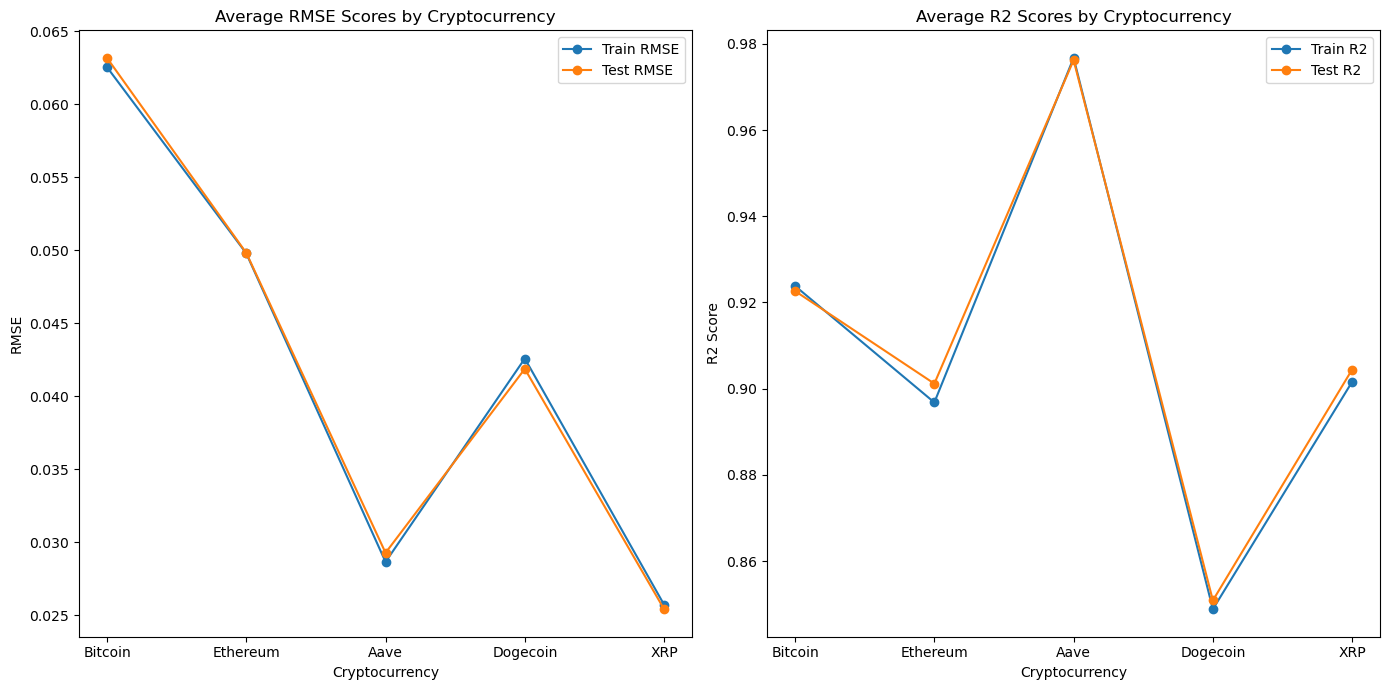

In [18]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()